### 0) Setup & load

In [2]:
# --- Setup & Load ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional KDE (use if available)
try:
    from scipy.stats import gaussian_kde
    _HAS_SCIPY = True
except Exception:
    _HAS_SCIPY = False

plt.rcParams["figure.figsize"] = (7, 4)
plt.rcParams["axes.grid"] = True

# Load your file (same name we saved before)
PATH = "synthetic_clinical_dataset.csv"
df = pd.read_csv(PATH)

# basic split
cases = df[df["diagnosis_label"] == 1].copy()
controls = df[df["diagnosis_label"] == 0].copy()

df.head()


,age,menopausal_status,bmi,parity,family_history,mht_use,brca_status,ca125,ultrasound_risk_score,tumor_size_cm,diagnosis_label
0,36,0,27.64,3,0,0,0,15.1,0.009,2.85,0
1,56,1,34.50,0,0,0,0,10.0,0.006,1.81,0
2,45,0,28.61,2,0,0,0,11.0,0.010,4.05,0
3,42,0,30.13,1,0,0,0,21.6,0.005,0.00,0
4,63,1,28.91,0,1,1,0,543.2,0.127,8.35,1


### 1) Distribution plots (overall + stratified by diagnosis)

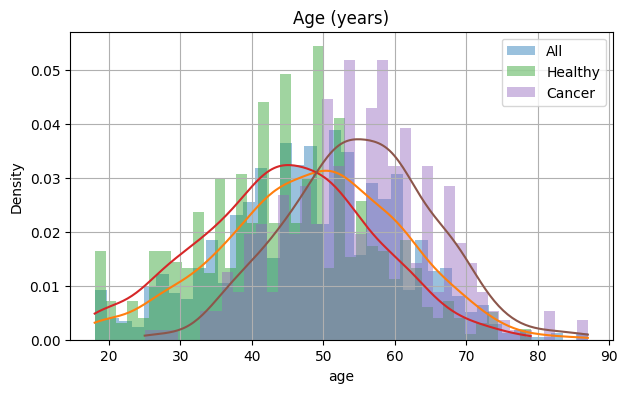

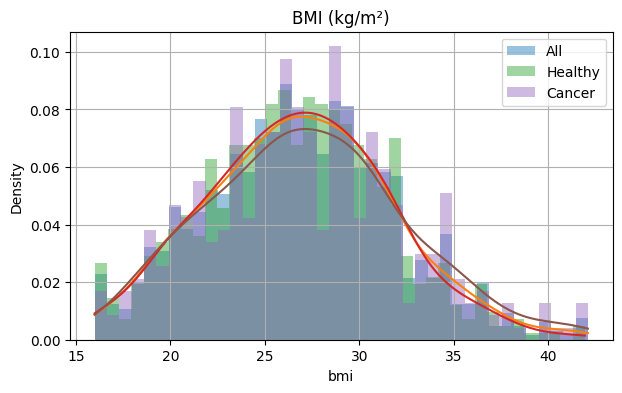

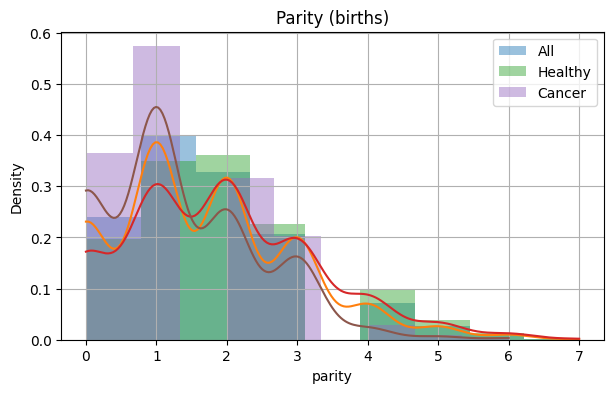

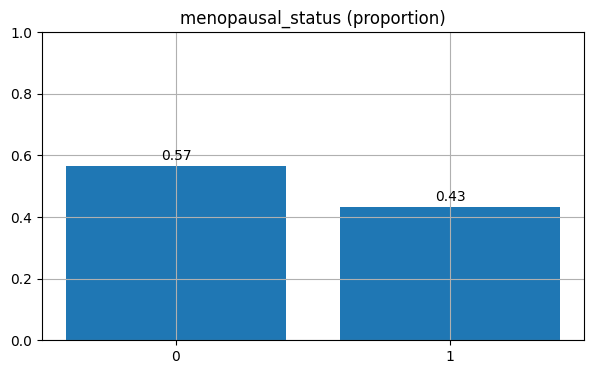

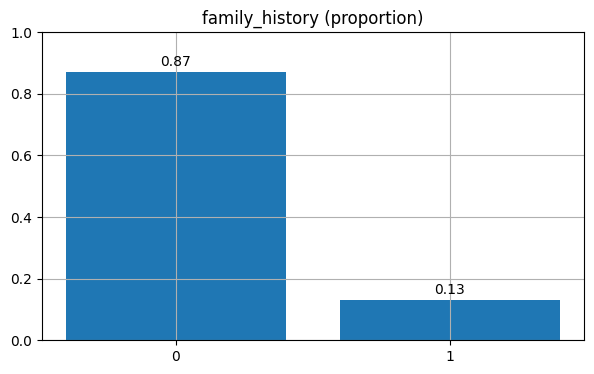

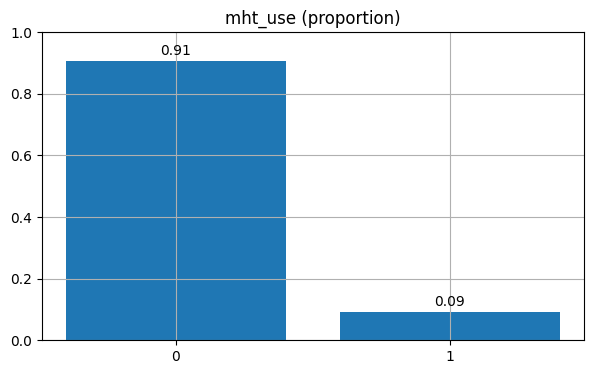

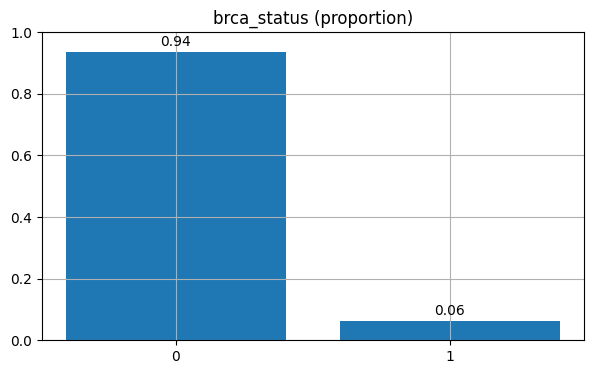

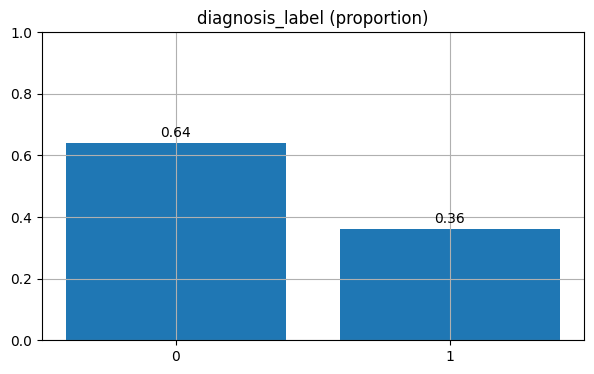

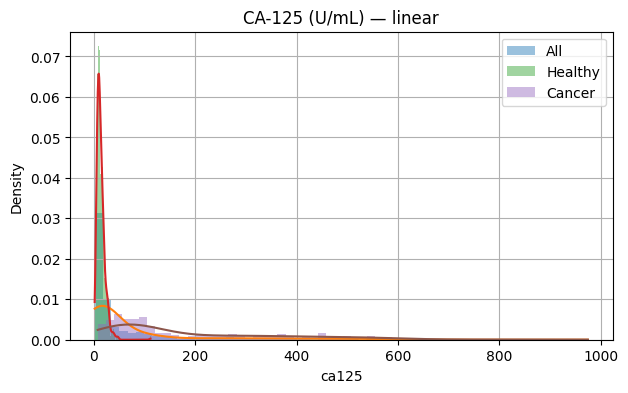

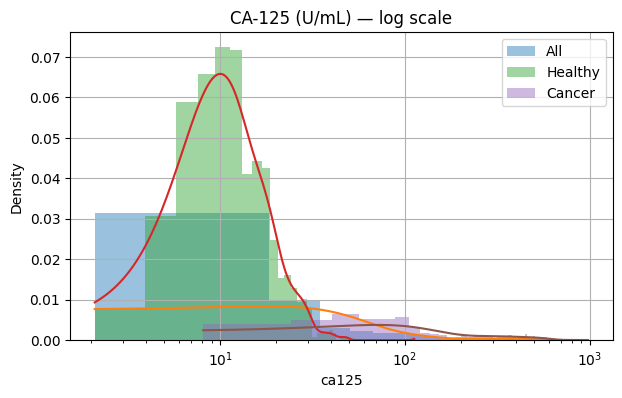

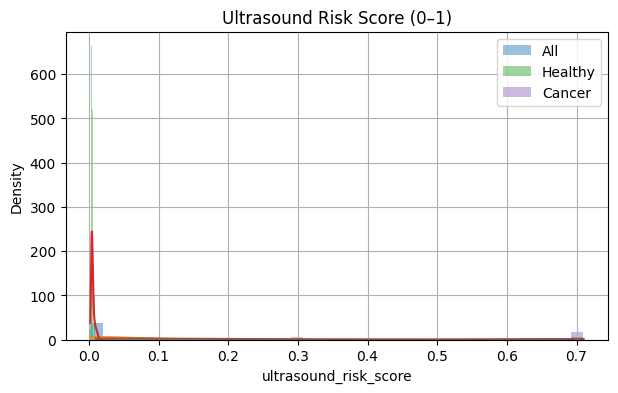

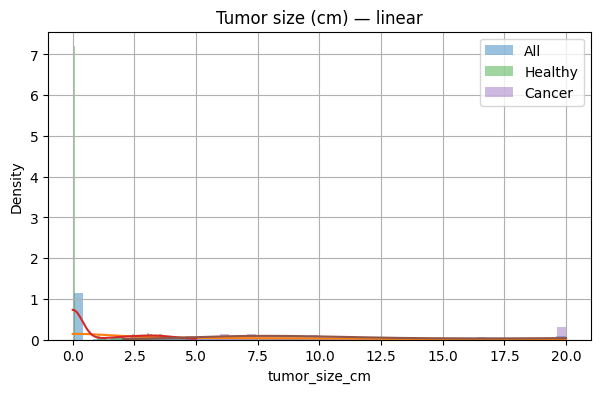

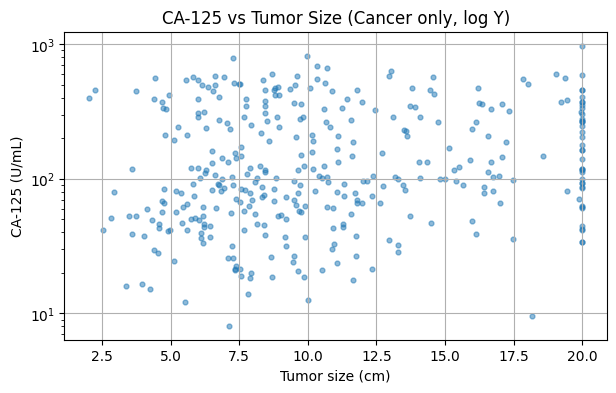

In [5]:
# --- Helpers for plotting ---
def plot_hist_kde(ax, data, bins=40, label=None, color=None, logx=False):
    data = np.asarray(data.dropna(), dtype=float)
    if logx:
        data = data[data > 0]  # only positive for log scale
        ax.set_xscale("log")

    ax.hist(data, bins=bins, alpha=0.45, label=label, density=True, edgecolor="none")
    if _HAS_SCIPY and len(data) > 1 and np.isfinite(data).all():
        try:
            kde = gaussian_kde(data)
            xs = np.linspace(data.min(), data.max(), 200)
            if logx:
                xs = np.geomspace(max(data.min(), 1e-3), data.max(), 200)
            ax.plot(xs, kde(xs))
        except Exception:
            pass

def plot_feature_distribution(feature, title=None, bins=40, logx=False):
    fig, ax = plt.subplots()
    plot_hist_kde(ax, df[feature], bins=bins, label="All", logx=logx)
    plot_hist_kde(ax, controls[feature], bins=bins, label="Healthy", logx=logx)
    plot_hist_kde(ax, cases[feature], bins=bins, label="Cancer", logx=logx)
    ax.set_title(title or feature)
    ax.set_xlabel(feature)
    ax.set_ylabel("Density")
    ax.legend()
    plt.show()

# --- Plot each feature ---
plot_feature_distribution("age", "Age (years)")
plot_feature_distribution("bmi", "BMI (kg/m²)")
plot_feature_distribution("parity", "Parity (births)", bins=9, logx=False)

# Binary features: bar charts
for col in ["menopausal_status","family_history","mht_use","brca_status","diagnosis_label"]:
    fig, ax = plt.subplots()
    vc_all = df[col].value_counts(normalize=True).sort_index()
    ax.bar(vc_all.index.astype(str), vc_all.values)
    ax.set_title(f"{col} (proportion)")
    ax.set_ylim(0, 1)
    for i, v in enumerate(vc_all.values):
        ax.text(i, v + 0.02, f"{v:.2f}", ha="center")
    plt.show()

# CA-125 is skewed; show linear + log scale
plot_feature_distribution("ca125", "CA-125 (U/mL) — linear", bins=60, logx=False)
plot_feature_distribution("ca125", "CA-125 (U/mL) — log scale", bins=60, logx=True)

# Ultrasound risk & tumor size
plot_feature_distribution("ultrasound_risk_score", "Ultrasound Risk Score (0–1)", bins=40, logx=False)
plot_feature_distribution("tumor_size_cm", "Tumor size (cm) — linear", bins=50, logx=False)

# Optional: a quick scatter to visualize the intended correlation (cases only)
fig, ax = plt.subplots()
ax.scatter(cases["tumor_size_cm"], cases["ca125"], s=12, alpha=0.5)
ax.set_xlabel("Tumor size (cm)")
ax.set_ylabel("CA-125 (U/mL)")
ax.set_yscale("log")
ax.set_title("CA-125 vs Tumor Size (Cancer only, log Y)")
plt.show()


### 2) Correlation matrix (+ brief clinical readout)

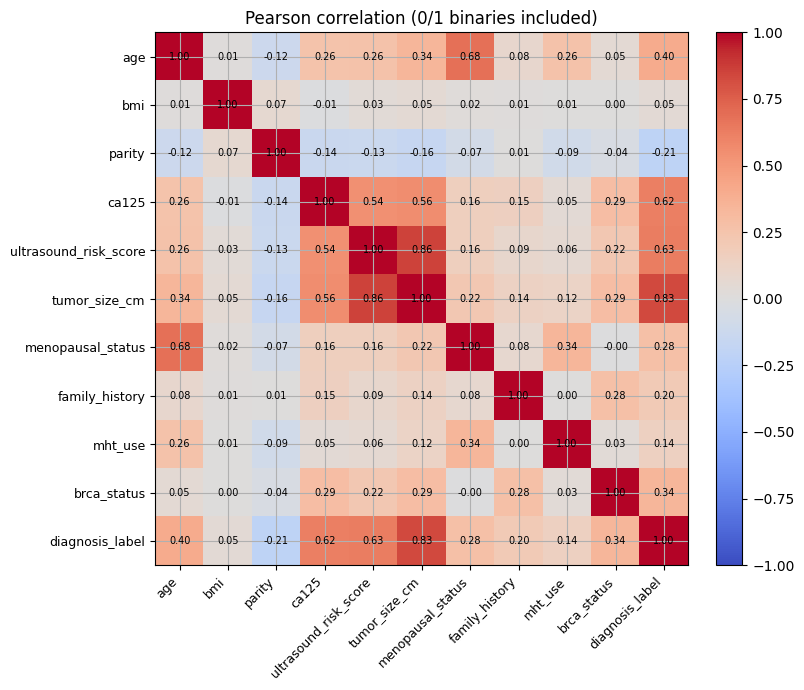

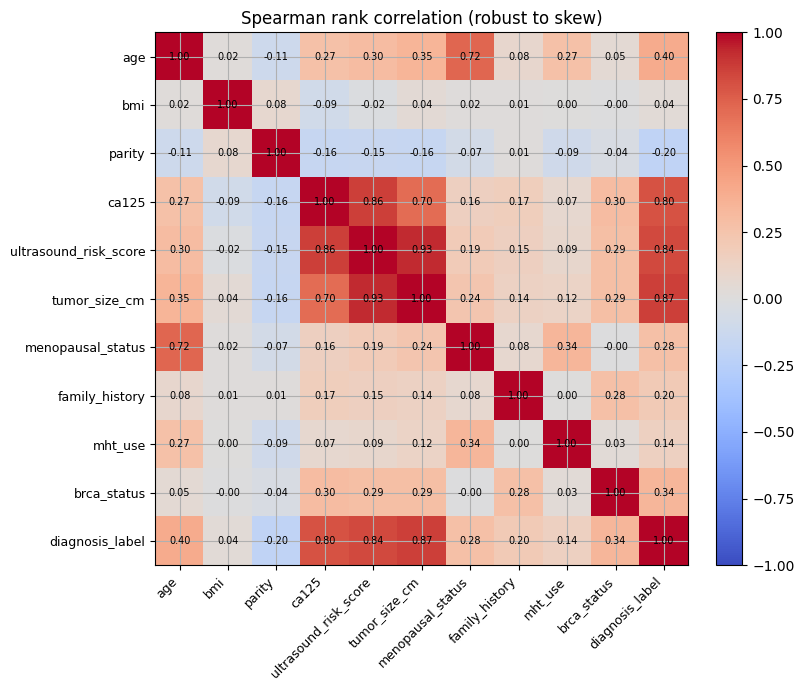


Selected correlations (Pearson):
tumor_size_cm          vs ca125                   : r =  0.561
tumor_size_cm          vs ultrasound_risk_score   : r =  0.859
ca125                  vs ultrasound_risk_score   : r =  0.541
age                    vs menopausal_status       : r =  0.683
family_history         vs brca_status             : r =  0.279
brca_status            vs age                     : r =  0.050


In [10]:
# Treat binaries as 0/1 numeric and compute Pearson & Spearman
numeric_cols = ["age","bmi","parity","ca125","ultrasound_risk_score","tumor_size_cm",
                "menopausal_status","family_history","mht_use","brca_status","diagnosis_label"]

corr_pearson  = df[numeric_cols].corr(method="pearson")
corr_spearman = df[numeric_cols].corr(method="spearman")

def plot_corr(mat, title):
    fig, ax = plt.subplots(figsize=(8.5, 7))
    im = ax.imshow(mat, cmap="coolwarm", vmin=-1, vmax=1)
    ax.set_xticks(range(len(mat.columns))); ax.set_yticks(range(len(mat.index)))
    ax.set_xticklabels(mat.columns, rotation=45, ha="right", fontsize=9)
    ax.set_yticklabels(mat.index, fontsize=9)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    ax.set_title(title)
    # annotate
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            val = mat.iat[i, j]
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color="black", fontsize=7)
    plt.tight_layout()
    plt.show()

plot_corr(corr_pearson,  "Pearson correlation (0/1 binaries included)")
plot_corr(corr_spearman, "Spearman rank correlation (robust to skew)")

# Quick clinical interpretation helper (prints a few expected pairs)
pairs_to_peek = [
    ("tumor_size_cm","ca125"),             # + in cancer
    ("tumor_size_cm","ultrasound_risk_score"), # strong +
    ("ca125","ultrasound_risk_score"),     # moderate +
    ("age","menopausal_status"),           # strong +
    ("family_history","brca_status"),      # +
    ("brca_status","age"),                 # negative (BRCA+ younger)
]
print("\nSelected correlations (Pearson):")
for a,b in pairs_to_peek:
    r = corr_pearson.loc[a,b]
    print(f"{a:<22s} vs {b:<24s}: r = {r: .3f}")


### 3) Plausibility checks vs our targets (pass/fail)

In [13]:
def pct(s): return 100*float(s)

checks = []

# cohort composition
checks.append(("Cancer fraction ≥ 30%", df["diagnosis_label"].mean() >= 0.30, df["diagnosis_label"].mean()))
# BRCA+ among cancer 10–20%
brca_case_rate = cases["brca_status"].mean()
checks.append(("BRCA+ among cases in [10%,20%]", 0.10 <= brca_case_rate <= 0.20, brca_case_rate))

# CA-125 behavior
healthy_high35 = (controls["ca125"] > 35).mean()
case_high200   = (cases["ca125"] > 200).mean()
checks.append(("Healthy CA-125 >35 U/mL ≈ 1–3%", 0.01 <= healthy_high35 <= 0.03, healthy_high35))
checks.append(("Cancer CA-125 >200 U/mL ≳ 30%", case_high200 >= 0.30, case_high200))

# Tumor size
median_size_cases = cases["tumor_size_cm"].median()
median_size_ctrl_nonzero = controls.loc[controls["tumor_size_cm"]>0, "tumor_size_cm"].median()
checks.append(("Median tumor size (cases) ~8–11 cm", 8.0 <= median_size_cases <= 11.0, median_size_cases))
if pd.notna(median_size_ctrl_nonzero):
    checks.append(("Median benign cyst (controls) ≈ 2–4 cm", 2.0 <= median_size_ctrl_nonzero <= 4.0, median_size_ctrl_nonzero))

# Risk score sanity
mean_risk_cases = cases["ultrasound_risk_score"].mean()
mean_risk_ctrls = controls["ultrasound_risk_score"].mean()
checks.append(("Mean risk (cases) > Mean risk (controls)", mean_risk_cases > mean_risk_ctrls, (mean_risk_cases, mean_risk_ctrls)))
checks.append(("Controls w/ no mass have low risk", (controls.loc[controls["tumor_size_cm"]==0, "ultrasound_risk_score"].mean() <= 0.1),
               controls.loc[controls["tumor_size_cm"]==0, "ultrasound_risk_score"].mean()))

# Age & BRCA relationship
checks.append(("BRCA+ cases skew younger (median)", cases.loc[cases["brca_status"]==1, "age"].median() <
                                           cases.loc[cases["brca_status"]==0, "age"].median(),
               (cases.loc[cases["brca_status"]==1, "age"].median(), cases.loc[cases["brca_status"]==0, "age"].median())))

# Print report
print("Plausibility checks:")
for desc, ok, val in checks:
    status = "PASS" if ok else "FAIL"
    print(f"[{status}] {desc:50s} -> {val}")


Plausibility checks:
[PASS] Cancer fraction ≥ 30%                              -> 0.361
[PASS] BRCA+ among cases in [10%,20%]                     -> 0.17174515235457063
[PASS] Healthy CA-125 >35 U/mL ≈ 1–3%                     -> 0.02034428794992175
[PASS] Cancer CA-125 >200 U/mL ≳ 30%                      -> 0.3490304709141274
[PASS] Median tumor size (cases) ~8–11 cm                 -> 9.59
[PASS] Median benign cyst (controls) ≈ 2–4 cm             -> 3.03
[PASS] Mean risk (cases) > Mean risk (controls)           -> (np.float64(0.29444598337950134), np.float64(0.005449139280125196))
[PASS] Controls w/ no mass have low risk                  -> 0.004321739130434783
[PASS] BRCA+ cases skew younger (median)                  -> (np.float64(51.0), np.float64(56.0))


### 4) Edge-case validation (no impossible values)

In [16]:
# Ranges & types
assert (df["age"].between(18, 90)).all(), "Age out of bounds"
assert (df["bmi"].between(16, 45)).all(), "BMI out of bounds"
assert (df["parity"].between(0, 8)).all(), "Parity out of bounds"
assert (df["tumor_size_cm"] >= 0).all() and (df["tumor_size_cm"] <= 20).all(), "Tumor size out of bounds"
assert (df["ca125"] >= 0).all() and (df["ca125"] <= 2000).all(), "CA-125 out of bounds"
assert (df["ultrasound_risk_score"].between(0, 1)).all(), "Risk score out of [0,1]"

# Binary integrity
for col in ["menopausal_status","family_history","mht_use","brca_status","diagnosis_label"]:
    vals = set(df[col].unique().tolist())
    assert vals.issubset({0,1}), f"Non-binary values found in {col}: {vals}"

# NA check
na_counts = df.isna().sum()
print("NA counts per column:\n", na_counts)

print("Edge-case validation COMPLETE ✅")


NA counts per column:
 age                      0
menopausal_status        0
bmi                      0
parity                   0
family_history           0
mht_use                  0
brca_status              0
ca125                    0
ultrasound_risk_score    0
tumor_size_cm            0
diagnosis_label          0
dtype: int64
Edge-case validation COMPLETE ✅
